In [2]:
## import packages
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as st
from sklearn import ensemble, tree, linear_model
import missingno as msno
import psycopg2
from getpass import getpass
from sqlalchemy import create_engine
from datetime import date, datetime
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings('ignore')

In [3]:
hostname = input("Enter server hostname: ")
username = input("Enter username: ")
password = getpass("Enter password: ")
database_name = input("Enter database name: ")

Enter server hostname: spinup-db001ec7.cluster-c9ukc6s0rmbg.us-east-1.rds.amazonaws.com
Enter username: introml568
Enter password: ········
Enter database name: urineculture


In [7]:
alchemy_engine = create_engine(f"postgresql+psycopg2://{username}:{password}@{hostname}/{database_name}",  pool_recycle=3600)


In [9]:
# Connect using SQL Alchemy to support pandas mapping
alchemy_engine = create_engine(f"postgresql+psycopg2://{username}:{password}@{hostname}/{database_name}",  pool_recycle=3600)
db_connection = alchemy_engine.connect();

This was running fine but had a problem when I was printing

In [28]:
df=pd.read_sql("select * from results", db_connection);
df.head()

,id,patid,UCX_abnormal,ua_bacteria,ua_bili,ua_blood,ua_clarity,ua_color,ua_epi,ua_glucose,...,skin_preps,smoking_deterrents,thyroid_preps,unclassified_drug_products,vitamins,dispo,UTI_diag,split,abxUTI,alt_diag
0,1,1,1,few,negative,negative,clear,yellow,small,negative,...,0,0,0,0,0,Admit,1,training,1,0
1,2,1,0,many,negative,small,clear,yellow,None,negative,...,0,0,0,0,1,Admit,1,training,1,0
2,3,2,1,few,negative,negative,clear,yellow,small,negative,...,0,0,1,1,0,Discharge,0,training,0,0
3,4,3,1,many,negative,negative,not_clear,yellow,None,negative,...,0,0,0,0,1,Admit,1,training,1,0
4,5,4,0,moderate,small,negative,clear,orange,None,negative,...,0,0,0,0,0,AMA,0,training,0,0


In [29]:
df.drop(["UCX_abnormal", "split", "abxUTI", "alt_diag"], axis = 1, inplace=True)
df.head()

,id,patid,ua_bacteria,ua_bili,ua_blood,ua_clarity,ua_color,ua_epi,ua_glucose,ua_ketones,...,pre_natal_vitamins,psychotherapeutic_drugs,sedative_hypnotics,skin_preps,smoking_deterrents,thyroid_preps,unclassified_drug_products,vitamins,dispo,UTI_diag
0,1,1,few,negative,negative,clear,yellow,small,negative,negative,...,0,0,0,0,0,0,0,0,Admit,1
1,2,1,many,negative,small,clear,yellow,None,negative,negative,...,0,0,0,0,0,0,0,1,Admit,1
2,3,2,few,negative,negative,clear,yellow,small,negative,negative,...,0,1,1,0,0,1,1,0,Discharge,0
3,4,3,many,negative,negative,not_clear,yellow,None,negative,negative,...,0,0,0,0,0,0,0,1,Admit,1
4,5,4,moderate,small,negative,clear,orange,None,negative,small,...,0,0,0,0,0,0,0,0,AMA,0


# Preprocessing and EDA

### Removing NAs

In [30]:
#lots of NAs observed in the given data
df.isna().sum()

id                                0
patid                             0
ua_bacteria                   30225
ua_bili                         720
ua_blood                         28
                              ...  
thyroid_preps                     0
unclassified_drug_products        0
vitamins                          0
dispo                            54
UTI_diag                          0
Length: 216, dtype: int64

In [38]:
len(df)

80387

In [58]:
#removing variables with too many NAs
df=df.drop(df.loc[:,df.isnull().sum()>4000], axis=1)
#removing all NAs from the remaining variables 
df=df.dropna()
df.shape

(75622, 144)

<AxesSubplot:>

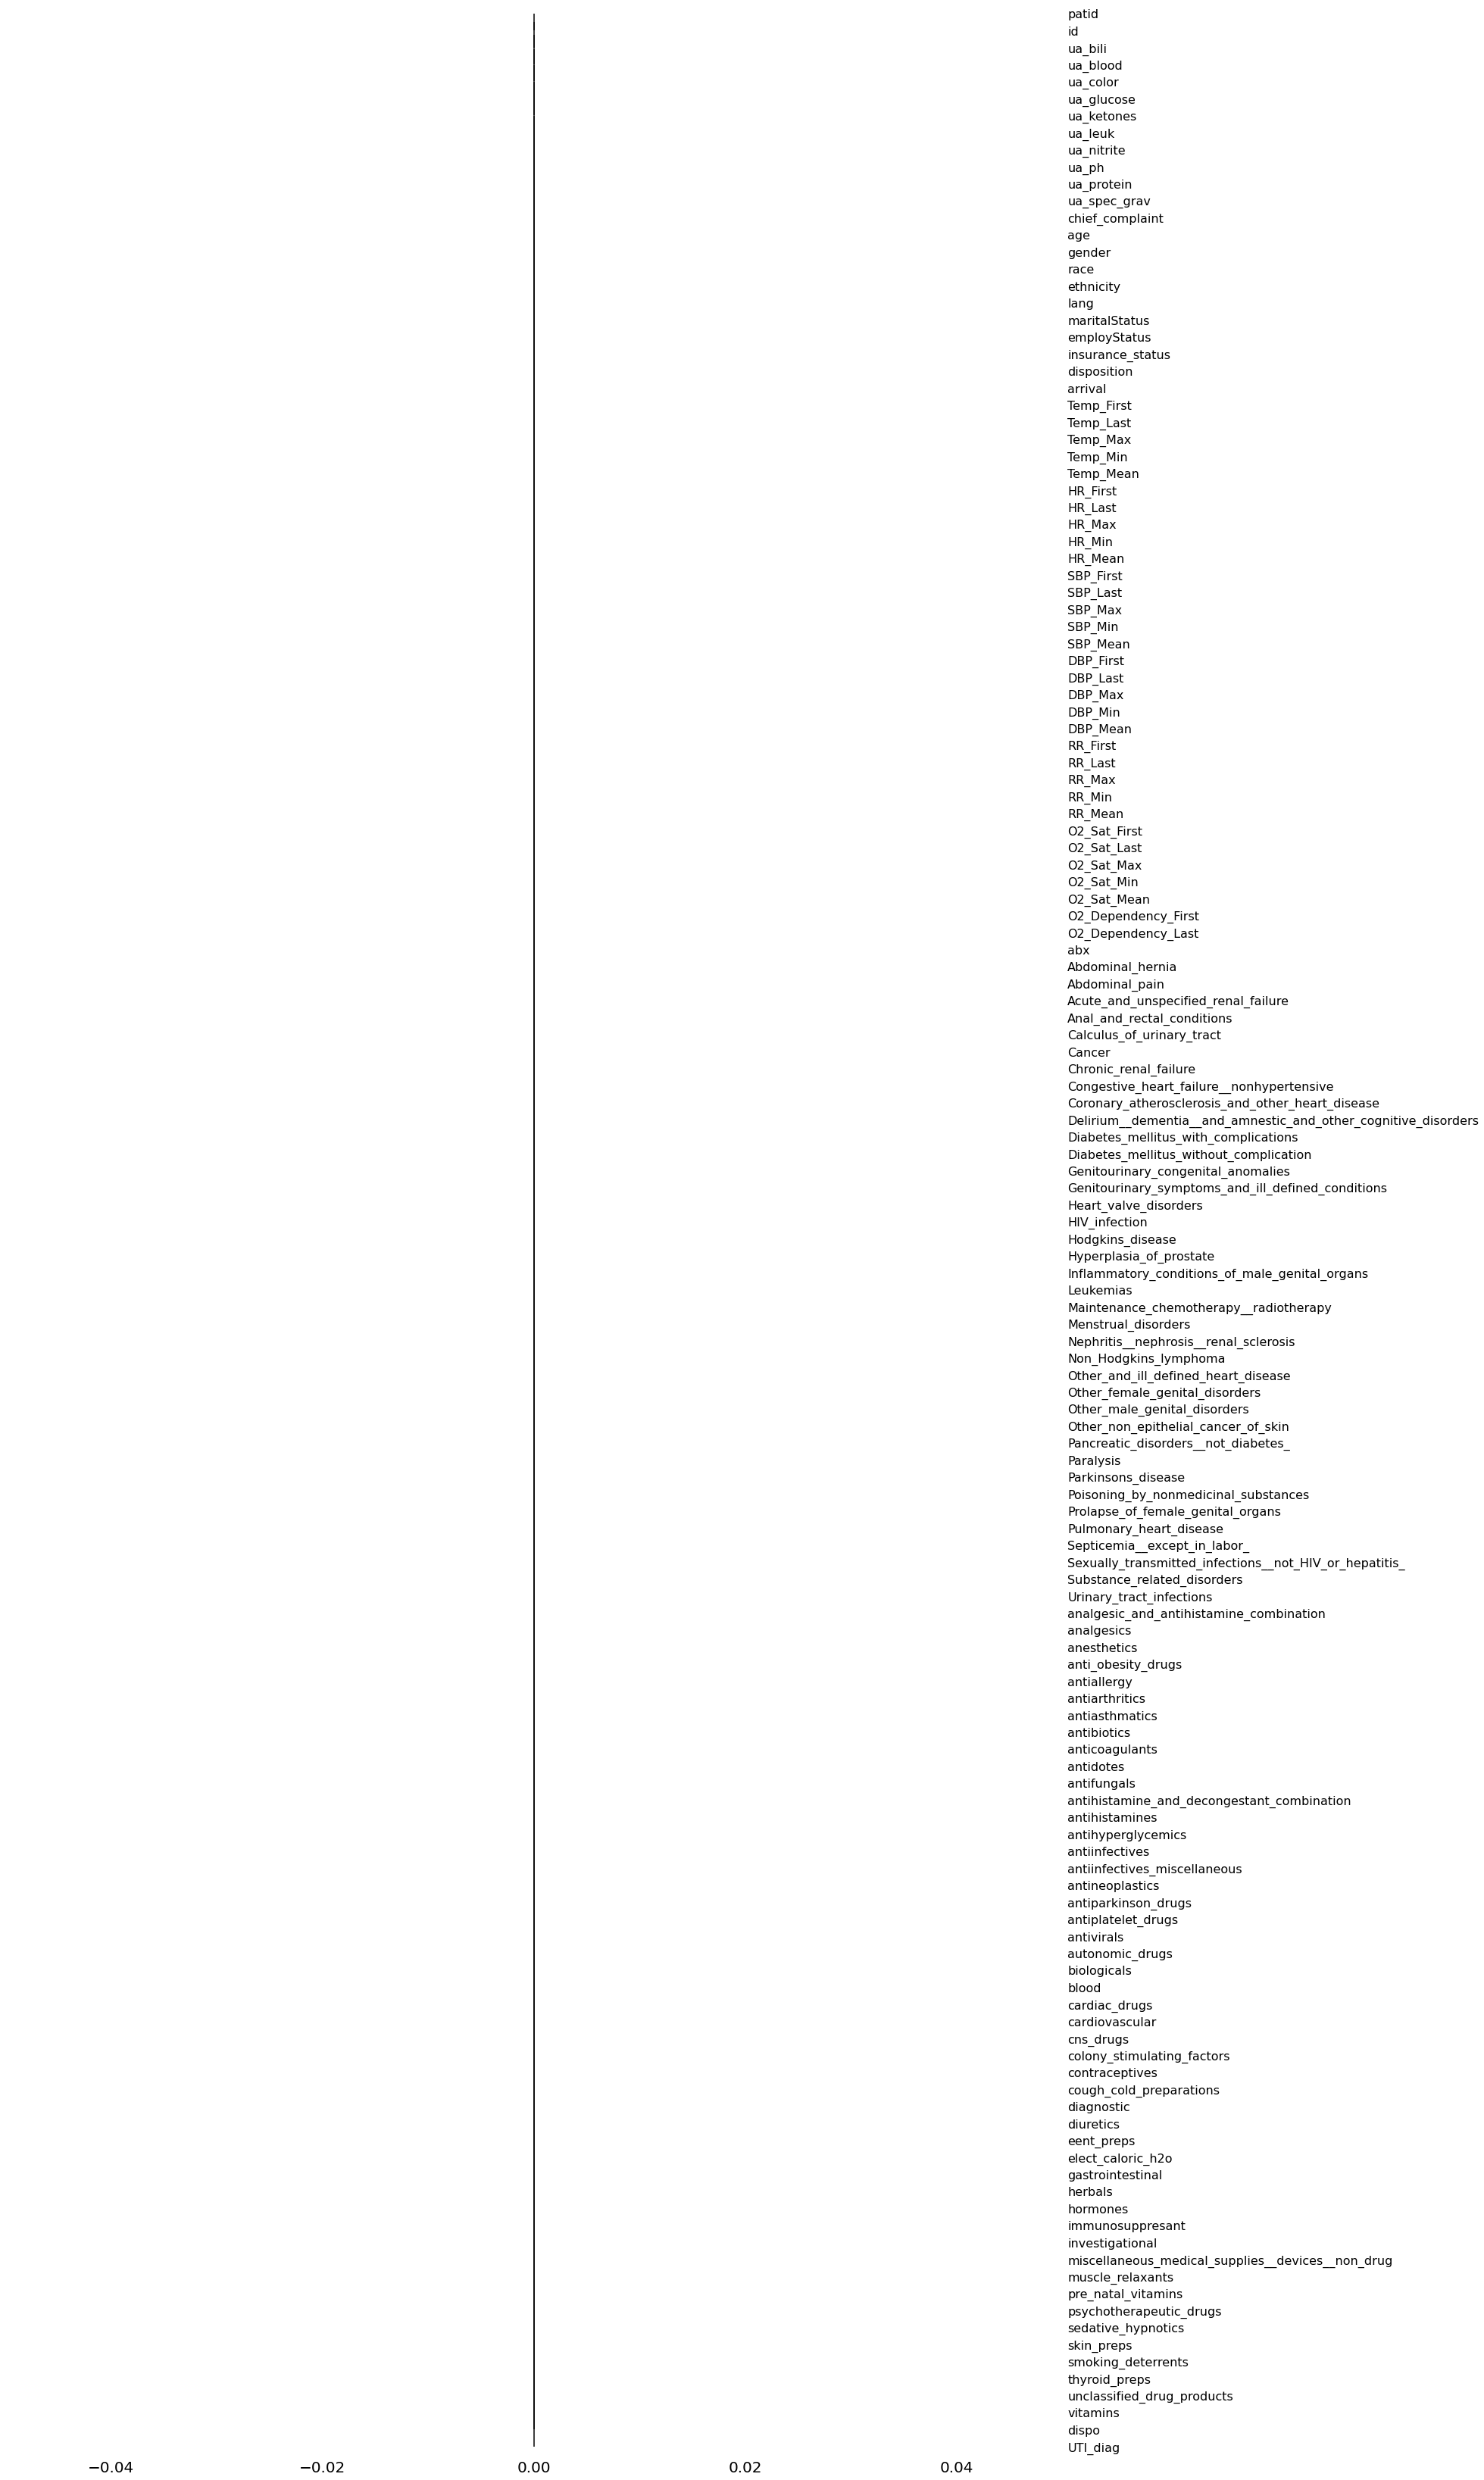

In [67]:
#check the correlation of variables using dendrogram
msno.dendrogram(df)

According to the dendrogram, all variables in the datasets are extremely correlated, so further trimming is needed. The reference paper provided us with a reduced set of 10 variables based on expert knowledge and literature review, and that will be used to reduce the number of variables. 

In [68]:
#re-importing the data
data=pd.read_sql("select * from results", db_connection);
data.head()

,id,patid,UCX_abnormal,ua_bacteria,ua_bili,ua_blood,ua_clarity,ua_color,ua_epi,ua_glucose,...,skin_preps,smoking_deterrents,thyroid_preps,unclassified_drug_products,vitamins,dispo,UTI_diag,split,abxUTI,alt_diag
0,1,1,1,few,negative,negative,clear,yellow,small,negative,...,0,0,0,0,0,Admit,1,training,1,0
1,2,1,0,many,negative,small,clear,yellow,None,negative,...,0,0,0,0,1,Admit,1,training,1,0
2,3,2,1,few,negative,negative,clear,yellow,small,negative,...,0,0,1,1,0,Discharge,0,training,0,0
3,4,3,1,many,negative,negative,not_clear,yellow,None,negative,...,0,0,0,0,1,Admit,1,training,1,0
4,5,4,0,moderate,small,negative,clear,orange,None,negative,...,0,0,0,0,0,AMA,0,training,0,0


In [69]:
list(data.columns)

['id',
 'patid',
 'UCX_abnormal',
 'ua_bacteria',
 'ua_bili',
 'ua_blood',
 'ua_clarity',
 'ua_color',
 'ua_epi',
 'ua_glucose',
 'ua_ketones',
 'ua_leuk',
 'ua_nitrite',
 'ua_ph',
 'ua_protein',
 'ua_rbc',
 'ua_spec_grav',
 'ua_urobili',
 'ua_wbc',
 'CVA_tenderness',
 'abd_tenderness',
 'abd_soft',
 'abd_distended',
 'abd_gaurding',
 'abd_mass',
 'abd_rebound',
 'abd_rigidity',
 'back_pain',
 'fatigue',
 'fever',
 'vag_bleeding',
 'vag_discharge',
 'abd_distended2',
 'abd_pain',
 'gen_neg',
 'pelvic_pain',
 'alert',
 'ams',
 'weakness',
 'oriented',
 'psychiatric_confusion',
 'flank_pain',
 'dec_urine_vol',
 'diff_urinating',
 'dysuria',
 'hematuria',
 'polyuria',
 'chief_complaint',
 'age',
 'gender',
 'race',
 'ethnicity',
 'lang',
 'maritalStatus',
 'employStatus',
 'insurance_status',
 'disposition',
 'arrival',
 'Temp_First',
 'Temp_Last',
 'Temp_Max',
 'Temp_Min',
 'Temp_Mean',
 'HR_First',
 'HR_Last',
 'HR_Max',
 'HR_Min',
 'HR_Mean',
 'SBP_First',
 'SBP_Last',
 'SBP_Max',
 'SB

### feature selection 

In [78]:
selected_var =["age", "gender", "ua_leuk", "ua_nitrite", "ua_wbc", "ua_bacteria", "ua_blood", "ua_epi", 
               "Urinary_tract_infections", "dysuria", "UTI_diag"]
data=data[selected_var]
data.head()

,age,gender,ua_leuk,ua_nitrite,ua_wbc,ua_bacteria,ua_blood,ua_epi,Urinary_tract_infections,dysuria,UTI_diag
0,83,Female,small,negative,moderate,few,negative,small,0,NaN,1
1,81,Female,negative,negative,small,many,small,None,0,NaN,1
2,78,Female,small,negative,small,few,negative,small,0,NaN,0
3,84,Female,large,negative,moderate,many,negative,None,0,0.0,1
4,55,Male,small,positive,small,moderate,negative,None,0,0.0,0


In [79]:
data.shape

(80387, 11)

In [82]:
#get rid of NAs
data=data.dropna()
data.shape

(24830, 11)

In [97]:
data.reset_index()
data.head()

,age,gender,ua_leuk,ua_nitrite,ua_wbc,ua_bacteria,ua_blood,ua_epi,Urinary_tract_infections,dysuria,UTI_diag
5,47,Female,small,negative,small,few,large,large,0,0.0,0
6,64,Male,large,negative,moderate,few,moderate,small,0,1.0,1
8,83,Male,small,negative,moderate,few,moderate,small,0,0.0,1
11,54,Female,small,negative,moderate,few,small,moderate,0,0.0,0
13,67,Female,large,negative,large,moderate,moderate,small,0,0.0,1


### transform the categorical variables  

In [ ]:
#get the categorical variables 
categorical_features = train.select_dtypes(include=[np.object])
categorical_features.columns

In [ ]:
#transform gender
from sklearn import preprocessing
le=preprocessing.LabelEncoder()
le.fit_transform(data["gender"])
data["gender"]=le.fit_transform(data["gender"])
data.head()

In [103]:
#transform the rest
le.fit_transform(data["ua_leuk"])
data["ua_leuk"]=le.fit_transform(data["ua_leuk"])
le.fit_transform(data["ua_nitrite"])
data["ua_nitrite"]=le.fit_transform(data["ua_nitrite"])
le.fit_transform(data["ua_wbc"])
data["ua_wbc"]=le.fit_transform(data["ua_wbc"])
le.fit_transform(data["ua_bacteria"])
data["ua_bacteria"]=le.fit_transform(data["ua_bacteria"])
le.fit_transform(data["ua_blood"])
data["ua_blood"]=le.fit_transform(data["ua_blood"])
le.fit_transform(data["ua_epi"])
data["ua_epi"]=le.fit_transform(data["ua_epi"])
le.fit_transform(data["Urinary_tract_infections"])
data["Urinary_tract_infections"]=le.fit_transform(data["Urinary_tract_infections"])
le.fit_transform(data["dysuria"])
data["dysuria"]=le.fit_transform(data["dysuria"])
data.head()

,age,gender,ua_leuk,ua_nitrite,ua_wbc,ua_bacteria,ua_blood,ua_epi,Urinary_tract_infections,dysuria,UTI_diag
5,47,0,4,0,4,0,0,0,0,0,0
6,64,1,0,0,1,0,1,4,0,1,1
8,83,1,4,0,1,0,1,4,0,0,1
11,54,0,4,0,1,0,4,1,0,0,0
13,67,0,0,0,0,3,1,4,0,0,1


In [192]:
correlation = numeric_features.corr()
print(correlation['UTI_diag'].sort_values(ascending = False),'\n')


UTI_diag                    1.000000
dysuria                     0.253426
age                         0.071571
Urinary_tract_infections    0.054449
Name: UTI_diag, dtype: float64 



We see that dysuria and age are the most correlated with UIT diagnosis. 

Index(['UTI_diag', 'dysuria', 'age', 'Urinary_tract_infections'], dtype='object')


<AxesSubplot:>

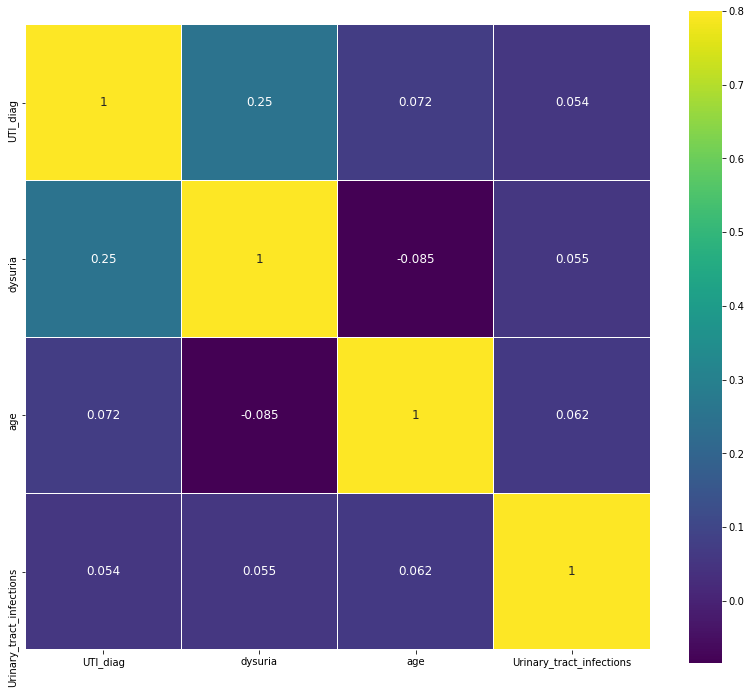

In [193]:
k= 11
cols = correlation.nlargest(k,'UTI_diag')['UTI_diag'].index
print(cols)
cm = np.corrcoef(train[cols].values.T)
f , ax = plt.subplots(figsize = (14,12))
sns.heatmap(cm, vmax=.8, linewidths=0.01,square=True,annot=True,cmap='viridis',
            linecolor="white",xticklabels = cols.values ,annot_kws = {'size':12},yticklabels = cols.values)

From above zoomed heatmap we see that dysuria and age are closely correlated.

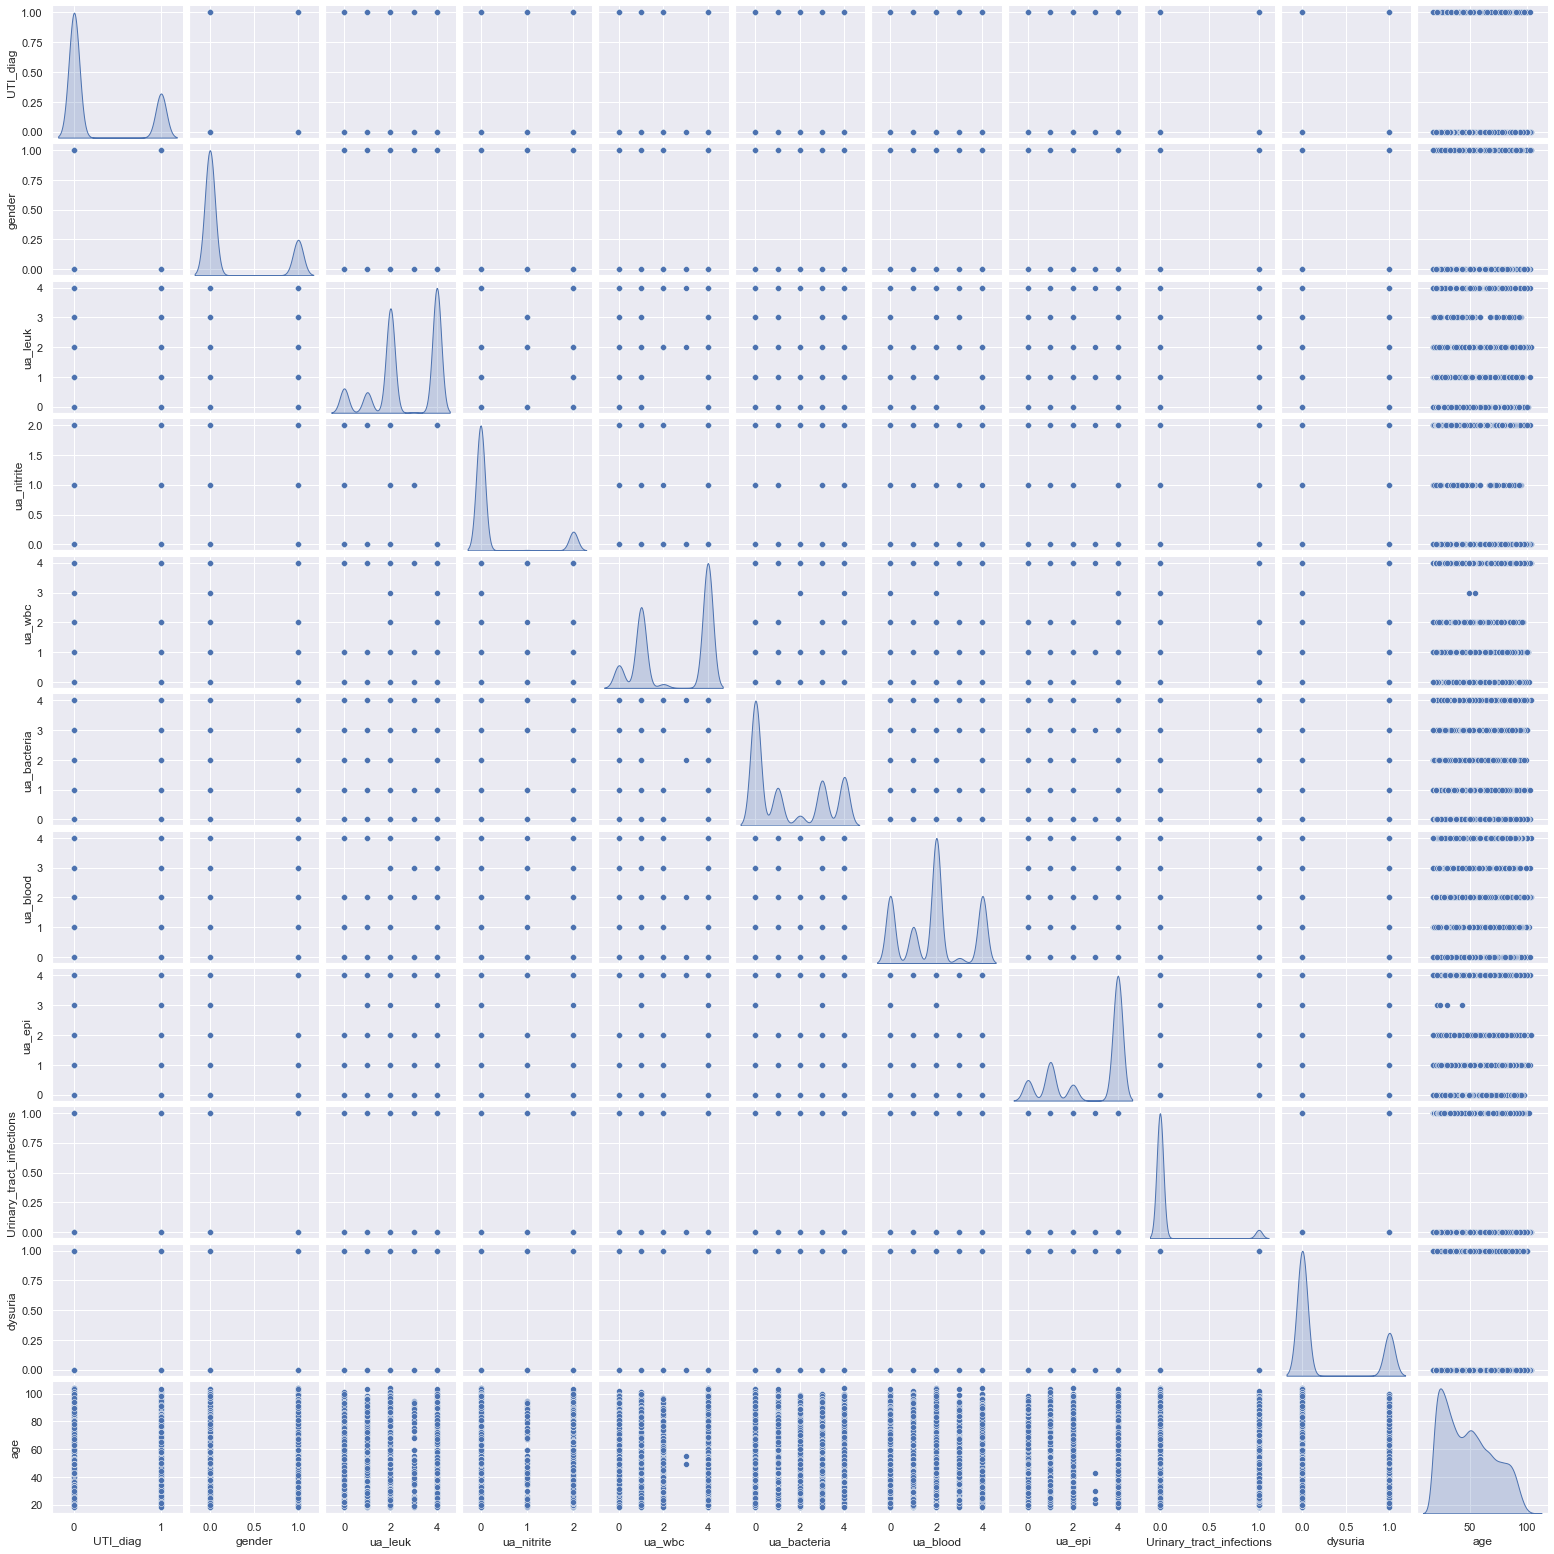

In [194]:
sns.set()
columns = ["UTI_diag", "gender", "ua_leuk", "ua_nitrite", "ua_wbc", "ua_bacteria", "ua_blood", "ua_epi", 
               "Urinary_tract_infections", "dysuria", "age"]
sns.pairplot(train[columns],size = 2 ,kind ='scatter',diag_kind='kde')
plt.show()

# splitting into train and test sets

In [31]:
from sklearn.model_selection import train_test_split

In [104]:
train, test = train_test_split(data,train_size = .8,random_state=50) 
train.shape , test.shape

((19864, 11), (4966, 11))

In [133]:
X_train = train.drop(['UTI_diag'], axis = 1)
y_train = train['UTI_diag']
X_test = test.drop(['UTI_diag'], axis = 1)
y_test = test['UTI_diag']

# Model fitting

### logistic regression

In [185]:
#logistic regression model 
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression()
logreg_model=logisticRegr.fit(X_train, y_train)
logreg_prediction = logreg_model.predict_proba(X_test)
score = logisticRegr.score(X_test, y_test)
print(score)

0.7682239226741845


In [170]:
#AUC
from sklearn.metrics import roc_auc_score
clf = LogisticRegression(solver="liblinear").fit(X_train, y_train)
#AUC of the test set
roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

0.7970095216286719

In [142]:
#PR AUC
from sklearn.metrics import average_precision_score, precision_recall_curve
# Data to plot precision - recall curve
y_score = clf.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)

0.5438680109912758


In [186]:
#for calibration curves
from sklearn.calibration import calibration_curve
logreg_y, logreg_x = calibration_curve(y_test, logreg_prediction[:,1], n_bins=10)
logreg_y, logreg_x 

(array([0.05435592, 0.12625418, 0.29745889, 0.38686131, 0.50735294,
        0.61306533, 0.61666667, 0.61428571, 0.625     ]),
 array([0.07330584, 0.13356016, 0.2475492 , 0.34665805, 0.44839225,
        0.55089513, 0.64718898, 0.74719938, 0.8219007 ]))

### random forest

In [117]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=1234).fit(X=X_train, y=y_train)
rf_prediction = rf_model.predict_proba(X_test)

In [144]:
#AUC
roc_auc_score(y_test, rf_prediction[:, 1])

0.7625108176883001

In [145]:
#PRAUC
precision, recall, thresholds = precision_recall_curve(y_test, rf_prediction[:, 1])
# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)

0.5050669210286342


In [187]:
#for calibration curves
rf_y, rf_x = calibration_curve(y_test, rf_prediction[:,1], n_bins=10)
rf_y, rf_x

(array([0.09753874, 0.25678119, 0.28810021, 0.37421384, 0.39393939,
        0.4787234 , 0.51557093, 0.55805243, 0.57978723, 0.63636364]),
 array([0.01891081, 0.14883234, 0.25030698, 0.35088945, 0.45299507,
        0.5531484 , 0.65162421, 0.75284619, 0.84798235, 0.94094949]))

### xgboost

In [126]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)

[19:45:45] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [157]:
import xgboost as xgb
params={
    'n_estimators':500,
    'objective': 'binary:logistic',
    'learning_rate': 0.05,
    'gamma':0.1,
    'subsample':0.8,
    'colsample_bytree':0.3,
    'min_child_weight':3,
    'max_depth':6,
    'seed':1024,
    }
clf = xgb.XGBClassifier(**params)
clf.fit(X_train,y_train)
y_pred = clf.predict_proba(X_test)[:,1]
print (roc_auc_score(y_test,y_pred))

0.8054903829590594


In [160]:
#PR AUC
y_score = clf.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)


0.5622852106594138


In [188]:
#for calibration curves
xg_y, xg_x = calibration_curve(y_test, y_pred, n_bins=10)
xg_y, xg_x

(array([0.0522918 , 0.14065511, 0.28571429, 0.37606838, 0.50229358,
        0.57238307, 0.59810127, 0.69402985, 0.68181818, 1.        ]),
 array([0.047041  , 0.14020728, 0.24949542, 0.34969617, 0.45025362,
        0.54781444, 0.64387187, 0.73851742, 0.83443687, 0.91237545]))

### calibration curves

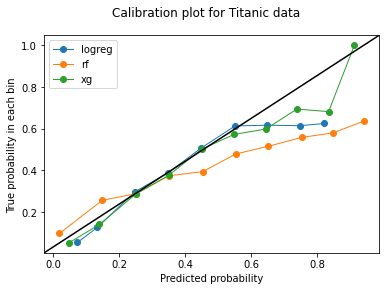

In [189]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
# calibration curves
fig, ax = plt.subplots()
plt.plot(logreg_x,logreg_y, marker='o', linewidth=1, label='logreg')
plt.plot(rf_x, rf_y, marker='o', linewidth=1, label='rf')
plt.plot(xg_x, xg_y, marker='o', linewidth=1, label='xg')

# reference line, legends, and axis labels
line = mlines.Line2D([0, 1], [0, 1], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
fig.suptitle('Calibration plot for UTI data')
ax.set_xlabel('Predicted probability')
ax.set_ylabel('True probability in each bin')
plt.legend()
plt.show() # it's not rendered correctly on GitHub, check blog post for actual pic

# Figures

[Text(0.5, 1.0, 'patient age at visit')]

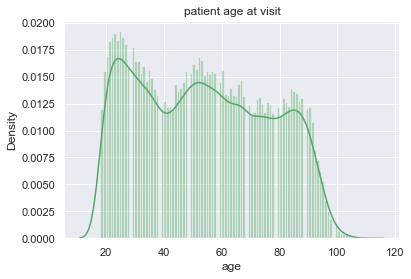

In [196]:
#hist for age
av=sns.distplot(df['age'], color='g', bins=100, hist_kws={'alpha': 0.4})
av.set(title='patient age at visit')

According to the historgram of the age distribtuion, most of the participates are between 20 to 100. While it is a quite wide range, the distribution of population in each age group is pretty even. 

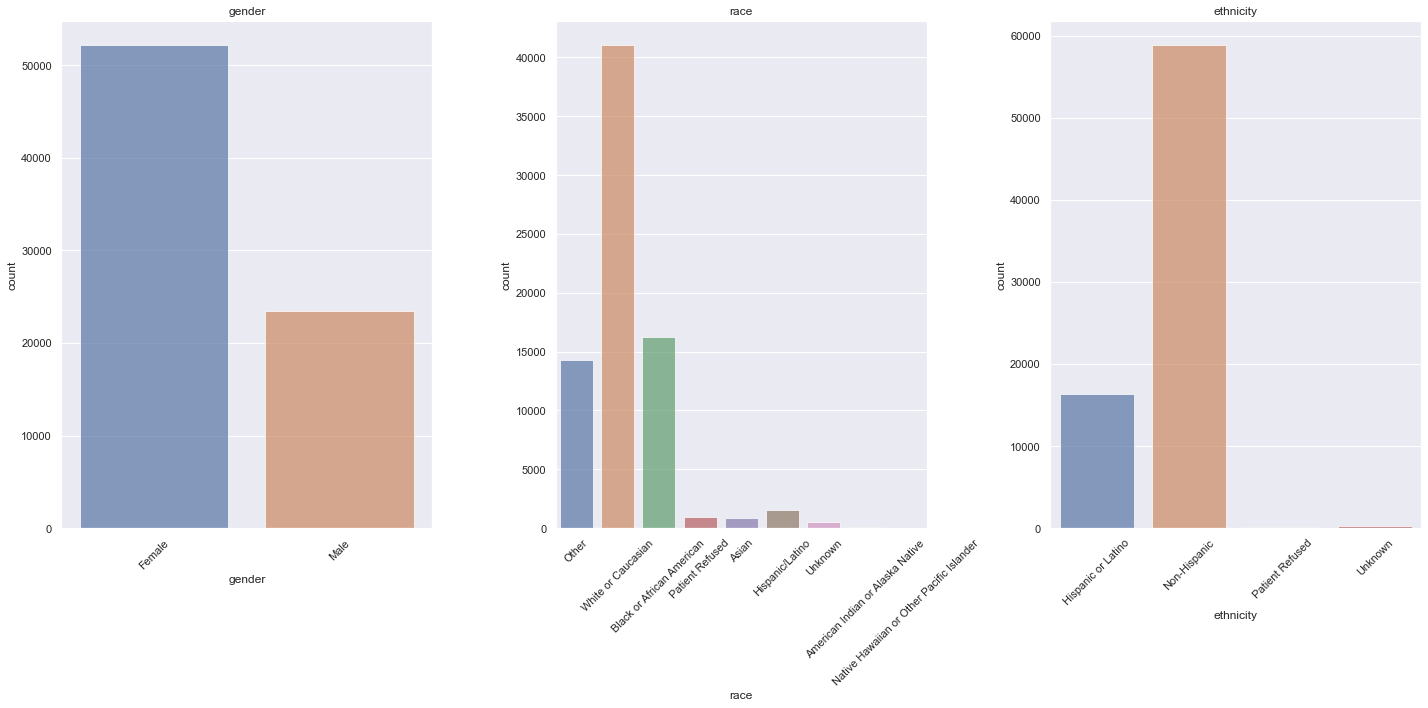

In [200]:
#gender, race, ethnicity bar plot 
cat_col = ['gender', 'race', 'ethnicity']
df_cat = df[cat_col]

# create figures and plots
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

for i, ax in enumerate(fig.axes):
    if i < len(df_cat.columns):
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
        sns.countplot(x=df_cat.columns[i], alpha=0.7, data=df_cat, ax=ax).set(title=cat_col[i])
fig.tight_layout()

According to the boxplots of gender, race, and ethinicity, we see that the recruited population has almost twice female than male; about half of the participants are white, with African Americans and other races making up the next tier; and lastly, there are about 3 times more Non-hispanic than hispanic. 

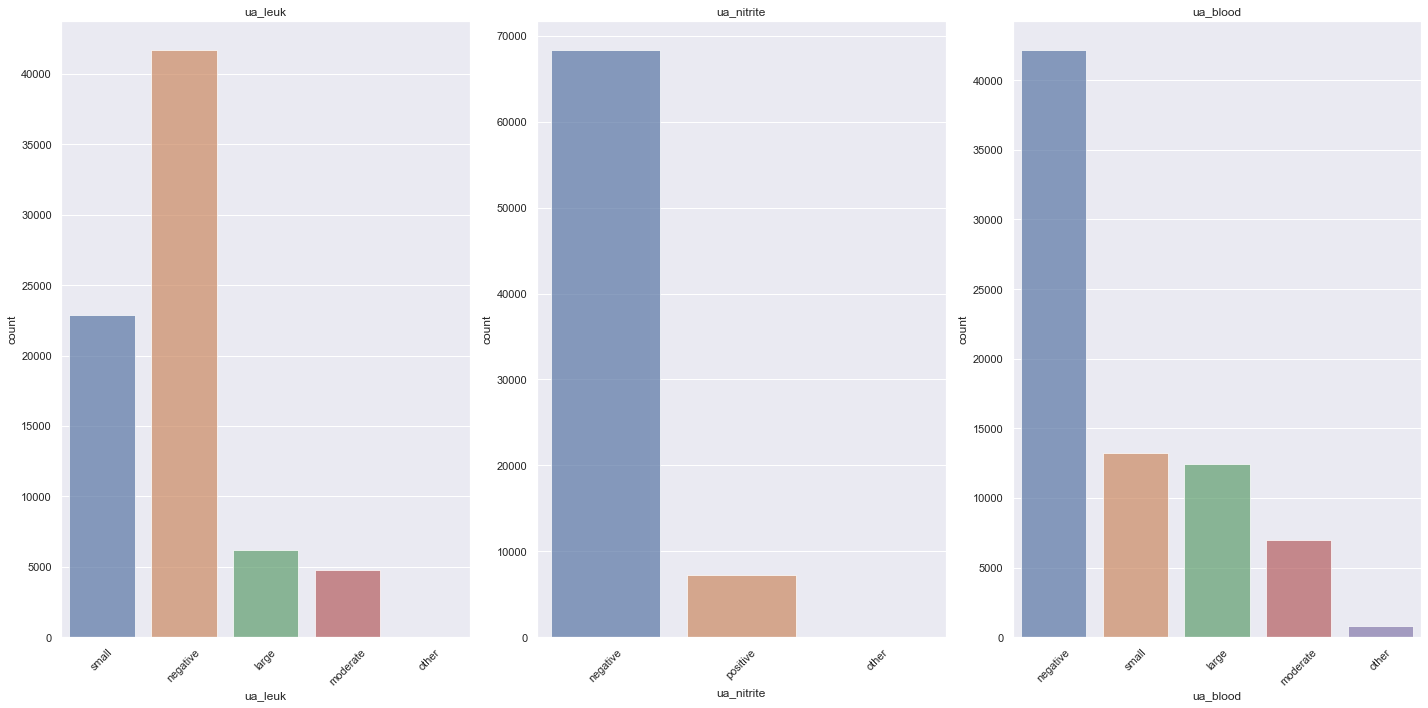

In [204]:
# gender, race, ethnicity bar plot 
cat_col = ["ua_leuk", "ua_nitrite", "ua_blood"]
df_cat = df[cat_col]

# create figures and plots
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

for i, ax in enumerate(fig.axes):
    if i < len(df_cat.columns):
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
        sns.countplot(x=df_cat.columns[i], alpha=0.7, data=df_cat, ax=ax).set(title=cat_col[i])
fig.tight_layout()

Given the boxplots for ua leukocytes level, ua nitrite results, and ua blood results, we see that most participants shows a negative ua leukocytes reuslt, a negative ua nitrite result, and a negative ua blood result. Even among patients with positive ua leukocytes and ua blood results, most of them show samll level of the two criterias. This finding suggests that we might need to put more weight on subjects with positive ua results. 

# Short Answer Questions

1. I eventually decided to use the 10 variables selected in the paper with expert support or shown in literatures to be significant. Since there were too many variables, and the algorithms I performed(Dendrogram and missingno) could distinguish which variables are correlated with each other and can be removed. I also think we should only include variables that are previously supported to be related to UTI so that we can make biological sense of our reslts, and avoid finding predictors that are due to confounding. 

2. Splitting the data into training and test set make sures that we are not training and testing our model on the data, avoids overfitting and makes our machine learning models more accurate. 

3.Data leakage is when information from outside the training dataset is used to create the model, when we are using the testing data when we aren't supoosed to. This can be a harmful thing in model creation as we might get an overly optimistic results and might cause our model to be invalid. 

In [10]:
#output data
#data.to_csv('/Users/hengjianli/Desktop/dat.csv',index=False)